<a href="https://colab.research.google.com/github/kjamartens/SMLM_dataAnalysis_handbook/blob/main/YSMLMS_intro_to_SMLM_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#YSMLMS - Introduction to Computational Analysis for SMLM

Programme:
1. Introduction
  With the phone-like questions
2. Overview of key analysis steps
  Effectively figures from the bioinf paper, or phd intro
3. Single-molecule segmentation: practical walkthrough
  Show the Huang (?) paper with the uniform filters and dilations, it's the best. Possibly also gloss over some others
4. Single-molecule localization: LSQ/MLE estimation mock-up
  Least squares is an easy mock-up. Grab the candidate ROI, simulate a PSF with x,y,int,sigma, calculate the total diff in least squares, minimize that. Show them how much AI can help here.
  Given this, and https://chemistry-europe.onlinelibrary.wiley.com/doi/10.1002/cphc.201300711 - Bernd/Sjoerds paper, its an easy transition to MLE, maybe show it's slightly better?
  Showcase fitting with 5-10 different intensities and show that fit accuracy drops.
5. Data visualisation
  Show that scatter is shit
  Show that plotting 2d Gaussians is slow
  Show that the Bernd's method of 2d histogram + blur with half the CRLB is good
6. Data interpretation
  FRC and NeNA
  FRC is easy to do
  For NeNA, go a little into data optimization - looking through the list every time you want to select the locs in the next frame is slow - use some accumarray or so
7. Related work

8. Discussion


Yea this'll take 1.5h.
Intro/Overview: 15 min
Segmentation: 15 min
Localization: 15 min
Data vis: 15 min
Data interpretation: 20 min
Wrap-up: 10 min
Total: 90 min

In [1]:
#@markdown ##Run this cell to load data
#@markdown Press the 'play button' to download required data for this module
%%capture
#Run cell to load required data
import os

#load data
if not os.path.isfile('DNAPAINT_substack_median_filtered.tif'):
  !wget 'https://github.com/Endesfelder-Lab/SMLMComputational/raw/main/Data/DNAPAINT_substack_median_filtered.tif' &> /dev/null

if not os.path.isfile('DNAPAINT_substack.tiff'):
  !wget 'https://github.com/Endesfelder-Lab/SMLMComputational/raw/main/Data/DNAPAINT_substack.tiff' &> /dev/null

#Print on success
print('Finshed loading data')

# Chapter 1: Single-molecule segmentation
The goal of this chapter is to select the spots from a SMLM movie that we want to localize.

Text(0.5, 0, 'X pixel')

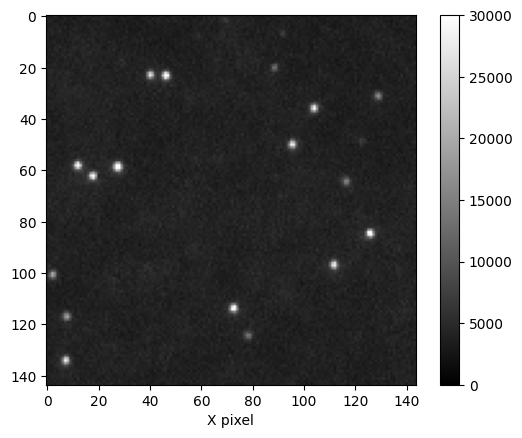

In [2]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np

#Let's look at the data we're working with!
im = io.imread('DNAPAINT_substack.tiff')

#First we read the data of a single frame
singleFrame_raw = im[30,:,:]

# ---------- Interaction ------------------
# Change the frame number and see what frames look good (or bad)
# ---------- End interaction --------------

#We plot this image with a gray colormap and minimum and maximum colormap values
#to showcase the individual localizations
plt.imshow(singleFrame_raw,cmap='gray',vmin=0,vmax=30000)
plt.colorbar()
plt.xlabel('X pixel')
# ---------- Interaction ------------------
# Add a label on the y-axis
# ---------- End interaction --------------

Nr of pixels under value of 0: 125


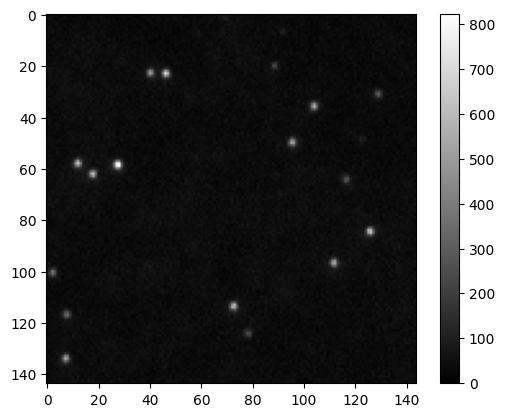

In [3]:
#To better use this, we need to correct it for the gain and offset of the camera:
gain = 50
offset = 40

#We divide by the gain and subtract the offset
singleFrame = singleFrame_raw/gain - offset
#All values that end up lower then 0, we set to 0 to prevent negativity
print(f"Nr of pixels under value of 0: {np.sum(np.where(singleFrame<0))}")
singleFrame[singleFrame<0] = 0

#Similar to before, we showcase the image
plt.imshow(singleFrame,cmap='gray')
plt.colorbar()
# ---------- Interaction ------------------
# Change the minimum/maximum color value to 0-->500
# Change the colormap to 'hot' and see if you prefer that
# ---------- End interaction --------------

## Segmentation logic
We follow the segmentation logic in this paper:
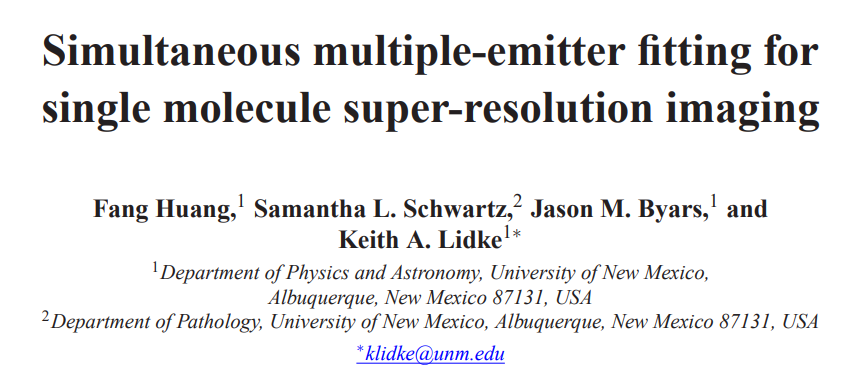

The relevant info is here:


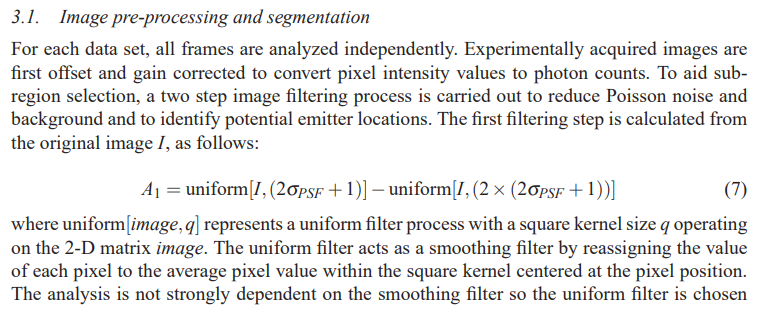
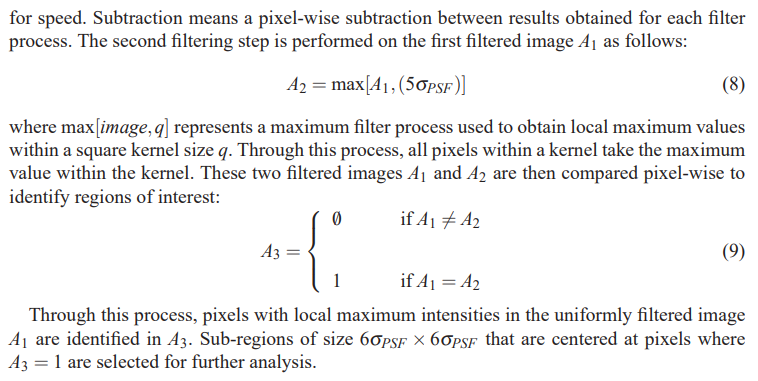

Obtained Sigma_PSF: 1.1073825503355705 px
q_a1_1: 3.214765100671141 px
q_a1_2: 6.429530201342282 px
q_a2: 5 px


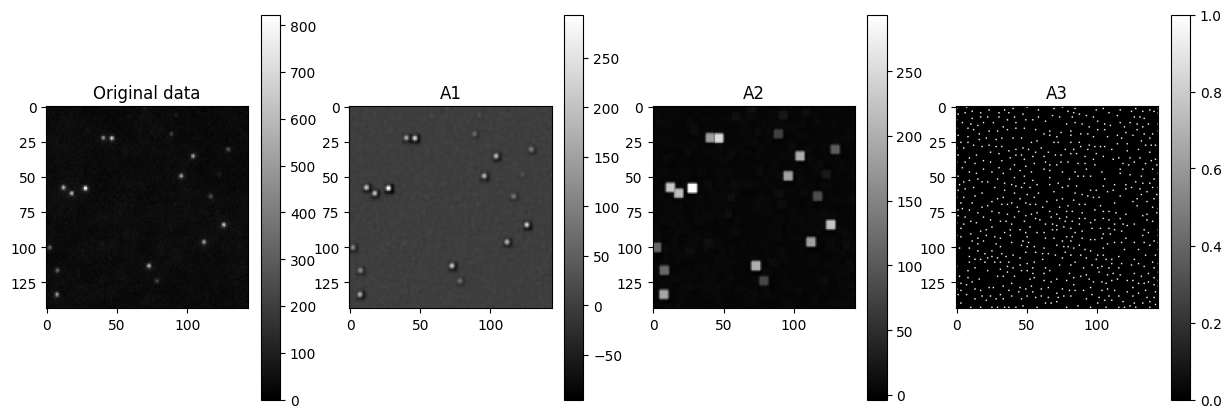

In [4]:
#First step: determine the size of sigma-PSF:
na = 1.49
pixel_size = 100
wavelength = 660

sigma_psf = wavelength / (4.0 * na * pixel_size)

print(f"Obtained Sigma_PSF: {sigma_psf} px")

from scipy.ndimage import uniform_filter, grey_dilation


q_a1_1 = 2 * sigma_psf + 1
q_a1_2 = 2*(2 * sigma_psf + 1)
q_a2 = int(5 * sigma_psf)

print(f"q_a1_1: {q_a1_1} px")
print(f"q_a1_2: {q_a1_2} px")
print(f"q_a2: {q_a2} px")

# Step 1: Bandpass filtering
# Enhances features roughly PSF-sized while suppressing background
A1 = uniform_filter(singleFrame, q_a1_1) - uniform_filter(singleFrame, q_a1_2)
# Step 2: Local maximum filtering
# Detect candidate emitters by finding local maxima
A2 = grey_dilation(A1, size=(q_a2, q_a2))  # max filter in neighborhood
# Step 3: Select true local peaks
A3 = (A1 == A2)

# Create a figure with 1 row and 3 columns
fig, (ax0,ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(15, 5))

im0 = ax0.imshow(singleFrame, cmap='gray')
ax0.set_title('Original data')
fig.colorbar(im0, ax=ax0)

im1 = ax1.imshow(A1, cmap='gray')
ax1.set_title('A1')
fig.colorbar(im1, ax=ax1)

im2 = ax2.imshow(A2, cmap='gray')
ax2.set_title('A2')
fig.colorbar(im2, ax=ax2)

im3 = ax3.imshow(A3, cmap='gray')
ax3.set_title('A3')
fig.colorbar(im3, ax=ax3)


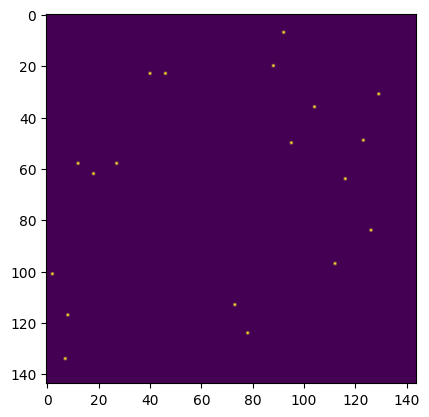

In [5]:
#There's a clear issue - it also is segmenting 'local peaks' that have very very very low intensity. Let's change that:
segmentation_roi_threshold = 20

# Step 3: Select true local peaks
A3 = (A1 == A2) & (A1 >= segmentation_roi_threshold)

plt.figure()
plt.imshow(A3)

# ---------- Interaction ------------------
# Show the original image and the final filtered image (A3) side-by-side
# Change the segmentation threshold and see what happens - then choose a value you're happy with
# ---------- End interaction --------------

## Extracting regions of interest
Finally, we want to use this image to obtain small regions-of-interest from our original data

In [6]:
# Convert peak mask to coordinates
roixy_pos = np.argwhere(A3==1) #np.argwhere returns the coordinates where the condition is true.
print(f'All ROI positions (in total {len(roixy_pos)} regions):') #Note the use of len(array) to get the length of an array
print(roixy_pos)
print('\n Third ROI position:')
roi_id = 2 #Python starts counting from 0
print(roixy_pos[roi_id])

All ROI positions (in total 19 regions):
[[  7  92]
 [ 20  88]
 [ 23  40]
 [ 23  46]
 [ 31 129]
 [ 36 104]
 [ 49 123]
 [ 50  95]
 [ 58  12]
 [ 58  27]
 [ 62  18]
 [ 64 116]
 [ 84 126]
 [ 97 112]
 [101   2]
 [113  73]
 [117   8]
 [124  78]
 [134   7]]

 Third ROI position:
[23 40]


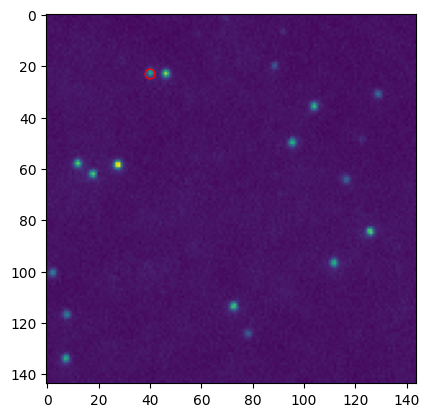

In [7]:
#Let's see if this makes sense:

plt.figure()
plt.imshow(singleFrame)
#Please note! The plt imshow flips x and y, so we need to plot the scatter like y-vs-x.
plt.scatter(roixy_pos[roi_id][1], roixy_pos[roi_id][0], s = 50, color='r', marker='o', facecolor='none')

# ---------- Interaction ------------------
# Choose a lovely region of interest you want to look at
# Create a for-loop to show the position of each spot
# ---------- End interaction --------------

## Extract all ROIs
Finally, we can use these positions to extract the individual ROIs

Text(0.5, 1.0, 'ROI index 2')

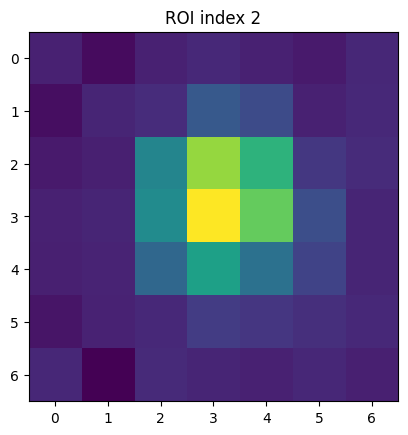

In [8]:
#We define the roi size by its radius - i.e. a center pixel plus/minus 'radius' pixels above/below/left/right from it
roi_px_radius = 3
roi_px_size = roi_px_radius*2+1

#We extract the x-y positions again
x_roi = roixy_pos[roi_id][0]
y_roi = roixy_pos[roi_id][1]
#We take data from the start to the end of the roi
spot_ROI = singleFrame[x_roi-roi_px_radius:x_roi+roi_px_radius+1,
                       y_roi-roi_px_radius:y_roi+roi_px_radius+1]

#We show it!
plt.figure()
plt.imshow(spot_ROI)
plt.title(f"ROI index {roi_id}")

In [9]:
#Now we can do this for all ROIs!

#We pre-allocate an array - we fill this with the data
all_rois = []

for roi_id in range(len(roixy_pos)):
  x_roi = roixy_pos[roi_id][0]
  y_roi = roixy_pos[roi_id][1]
  this_roi = singleFrame[x_roi-roi_px_radius:x_roi+roi_px_radius+1,
                         y_roi-roi_px_radius:y_roi+roi_px_radius+1]
  print(f'Found ROI {roi_id} with shape {np.shape(this_roi)}')
  #We append the ROI to the matrix 'all_rois'
  all_rois.append(this_roi)

Found ROI 0 with shape (7, 7)
Found ROI 1 with shape (7, 7)
Found ROI 2 with shape (7, 7)
Found ROI 3 with shape (7, 7)
Found ROI 4 with shape (7, 7)
Found ROI 5 with shape (7, 7)
Found ROI 6 with shape (7, 7)
Found ROI 7 with shape (7, 7)
Found ROI 8 with shape (7, 7)
Found ROI 9 with shape (7, 7)
Found ROI 10 with shape (7, 7)
Found ROI 11 with shape (7, 7)
Found ROI 12 with shape (7, 7)
Found ROI 13 with shape (7, 7)
Found ROI 14 with shape (7, 0)
Found ROI 15 with shape (7, 7)
Found ROI 16 with shape (7, 7)
Found ROI 17 with shape (7, 7)
Found ROI 18 with shape (7, 7)


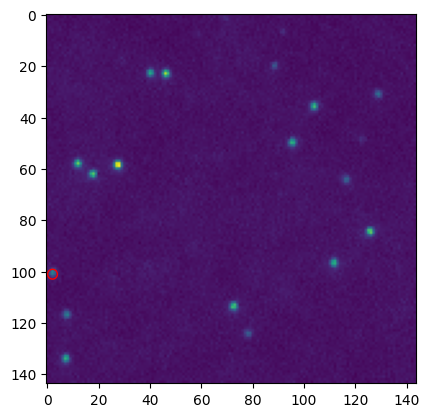

In [10]:
#Oh no! ROI 14 is a weird shape. Why could that be?

#Let's re-use the previous code and see where it is in the original image:
plt.figure()
plt.imshow(singleFrame)
#Please note! The plt imshow flips x and y, so we need to plot the scatter like y-vs-x.
plt.scatter(roixy_pos[14][1], roixy_pos[14][0], s = 50, color='r', marker='o', facecolor='none')


In [11]:
#Aha it's on the edge of the image! It cannot extract a neat PSF from it. Let's just add a check that we want our ROIs to be 7-by-7 exactly:

#We pre-allocate an array - we fill this with the data
all_rois = []
all_roi_positions = []

for roi_id in range(len(roixy_pos)):
  x_roi = roixy_pos[roi_id][0]
  y_roi = roixy_pos[roi_id][1]
  this_roi = singleFrame[x_roi-roi_px_radius:x_roi+roi_px_radius+1,
                         y_roi-roi_px_radius:y_roi+roi_px_radius+1]
  if np.shape(this_roi) == (roi_px_size,roi_px_size):
    print(f'Found ROI {roi_id} with shape {np.shape(this_roi)}')
    #We append the ROI to the matrix 'all_rois'
    all_rois.append(this_roi)
    all_roi_positions.append([x_roi,y_roi]) #We also store the middle-pixel positions for later.
  else:
    print(f"ROI {roi_id} has a weird shape: {np.shape(this_roi)}, and thus we do not include it!")

Found ROI 0 with shape (7, 7)
Found ROI 1 with shape (7, 7)
Found ROI 2 with shape (7, 7)
Found ROI 3 with shape (7, 7)
Found ROI 4 with shape (7, 7)
Found ROI 5 with shape (7, 7)
Found ROI 6 with shape (7, 7)
Found ROI 7 with shape (7, 7)
Found ROI 8 with shape (7, 7)
Found ROI 9 with shape (7, 7)
Found ROI 10 with shape (7, 7)
Found ROI 11 with shape (7, 7)
Found ROI 12 with shape (7, 7)
Found ROI 13 with shape (7, 7)
ROI 14 has a weird shape: (7, 0), and thus we do not include it!
Found ROI 15 with shape (7, 7)
Found ROI 16 with shape (7, 7)
Found ROI 17 with shape (7, 7)
Found ROI 18 with shape (7, 7)


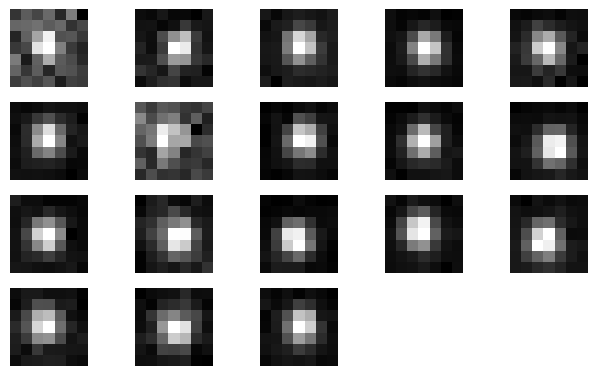

In [12]:
#Let's show all ROIs we have in a neat image:

#For this, we want to create a figure with some subplots. These 17 subplot do not fit in a 4-by-4 grid (that'll be 16 spots).
#We want to take the easy way out and make a 5-by-5 grid (room for 25, and we only fill 17)
#The value 5 can be found by rounding-up (ceiling) the square-root (sqrt) of the nr of Rois (len(all_rois))

subplot_1d_size = int(np.ceil(np.sqrt(len(all_rois)))) #it also needs to be an integer

plt.figure()
for roi_id in range(len(all_rois)):
  plt.subplot(subplot_1d_size,subplot_1d_size,roi_id+1)
  plt.imshow(all_rois[roi_id],cmap='gray')
  plt.gca().axis('off') #Turn off the axis for this current subplot
plt.tight_layout()


# ---------- Interaction ------------------
# Change the segmentation threshold way in the beginning to see what effect this has
# Change the ROI size and see if it reflects here
# Change the colormap to 'hot' or 'autumn' (or 'spring' if you like bright colors)

# Please at the end, change segmentation threshold back to 20, and ROI size back to radius=3 for the next parts.
# ---------- End interaction --------------

## Conclusion and generalization
We now extracted all spots from a single frame, and did a quick quality-check if they're nice or not. You obviously can do this for every frame, by just calling this for each frame in a for-loop.

We continue with fitting these ROIs that we found.

# Chapter 2: Localization
The goal of this chapter is to obtain sub-pixel positions belonging to our best guess of where the spots are.

## Known shortcuts for localization
In theory, an in-focus PSF is an Airy disc. This shape is ~ 99% the same as a Normal Distribution (Gaussian). A Gaussian is very easy to describe mathematically, an Airy disc isn't. Thus, we use a Gaussian-based fitting procedure to get the sub-pixel localization.

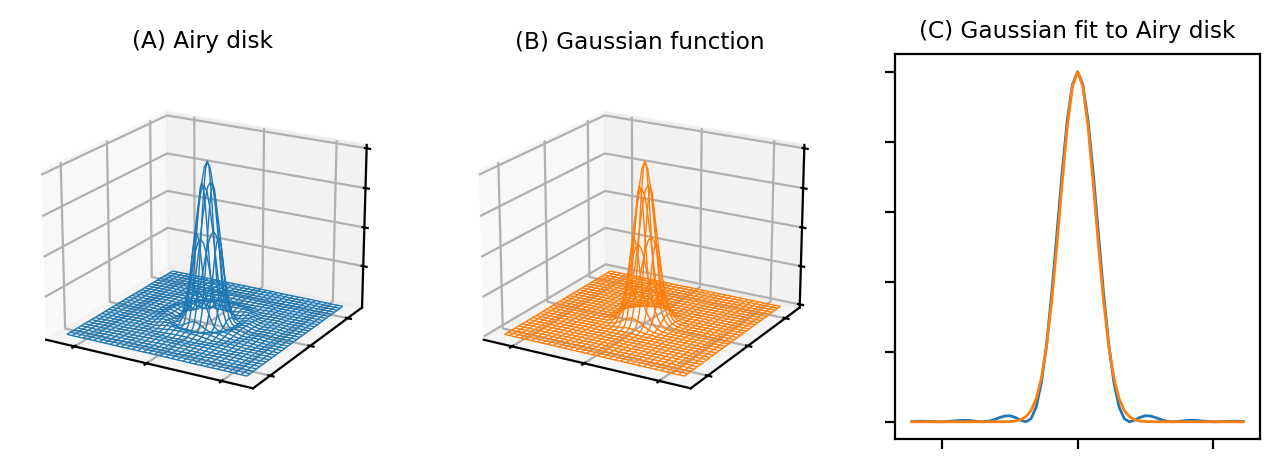

Image courtesy of bioimagebook.github.io, Pete Bankhead

Text(0.5, 0, 'X-position')

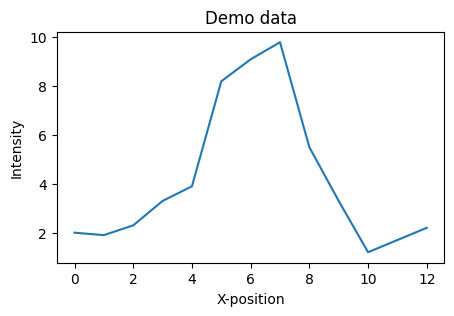

In [13]:
#First, let's think about our underlying problem. We reduce to a single dimension (rather than a 2D image) to make it a bit easier.

#We have some data:
demo_data = [2.0, 1.9, 2.3, 3.3, 3.9, 8.2, 9.1, 9.8, 5.5, 3.3, 1.2, 1.7, 2.2]

#Let's look at it:
plt.figure(figsize=(5,3))
plt.plot(demo_data)
plt.title("Demo data")
plt.ylabel('Intensity')
plt.xlabel('X-position')

This looks somewhat like a gaussian! Let's see if we can guess the properties of the gaussian.
The Gaussian equation looks like this:
$$
f(x) = I \cdot \frac{1}{\sigma \sqrt{2\pi}} \exp(-\frac{(x-\mu)^2}{2\sigma^2} + B)
$$

In which $I$ is the intensity, $\mu$ is the position, $\sigma$ is the standard deviation, and $B$ is the background.

Assessing the function at positions [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Values for these parameters: [ 2.00312271  2.03598651  2.26590634  3.25978922  5.82690174  9.4537868
 11.30865321  9.4537868   5.82690174  3.25978922  2.26590634  2.03598651
  2.00312271]


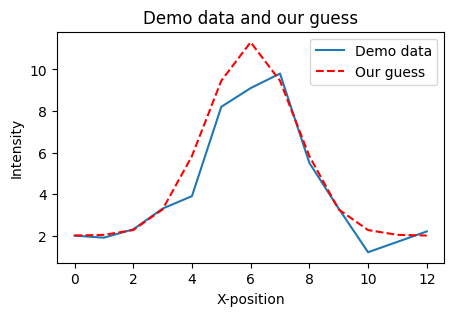

In [14]:
#Let's guess some values!
I = 35
B = 2
mu = 6
sigma = 1.5

#Let's make the function
assessment_x_pos = np.arange(0,13) #We want to asses the normal distribution at some x-positions
print(f"Assessing the function at positions {assessment_x_pos}")

f_gaussian = I*(1/(sigma*np.sqrt(2*np.pi)))*np.exp(-(assessment_x_pos-mu)**2/(2*sigma**2))+B
print(f"Values for these parameters: {f_gaussian}")

#And let's show them on top of the demo data
plt.figure(figsize=(5,3))
plt.plot(demo_data,label='Demo data')
plt.plot(assessment_x_pos,f_gaussian,'r--',label='Our guess')
plt.title("Demo data and our guess")
plt.ylabel('Intensity')
plt.xlabel('X-position')
plt.legend()

# ---------- Interaction ------------------
# Get a better guess!
# Make a prettier image by making the demo data a black line ('k-'), and adding gridlines (plt.grid())
# ---------- End interaction --------------

In [15]:
#While in theory we can just keep guessing and looking by eye, it's probably better to make this quantitative.

#The easiest way of getting an error matrix is the 'sum of squares' (also called least squares) method.
#This method takes the difference between our guess and our data, and squares that.
#The squaring ensures that (1) we never get negative values, and (2) large differences are more important than small differences

#So, let's calculate the sum of squares for our guess

sse = np.sum((f_gaussian-demo_data)**2)
print(f'Error of this guess: {sse}')

# ---------- Interaction ------------------
# Assure yourself that a better guess is a lower SSE value
# ---------- End interaction --------------

Error of this guess: 11.700511189570262


Found best parameters: [np.int64(30), np.float64(6.249999999999992), np.float64(1.5000000000000004), np.float64(1.9000000000000008)]
Found best SSE: 3.9079571393438313


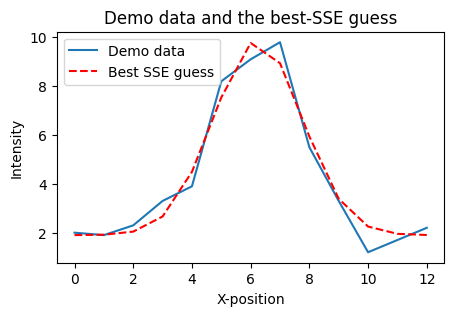

In [16]:
#Right, let's loop over a bunch of parameters and see when it is the best.

best_sse = np.inf
best_parameters = [0,0,0,0]

#We loop over a lot of different parameters
for mu_test in np.arange(4,8,0.05):        #We test the mu between reasonable bounds, every 0.1 pixel
  for sigma_test in np.arange(1,2,0.1):   #Similar for sigma/I/B
    for I_test in np.arange(20,50,2):
      for B_test in np.arange(1,3,0.1):
        #We make our gaussian with these parameters
        f_gaussian = I_test*(1/(sigma_test*np.sqrt(2*np.pi)))*np.exp(-(assessment_x_pos-mu_test)**2/(2*sigma_test**2))+B_test
        #We calculate the error:
        sse = np.sum((f_gaussian-demo_data)**2)

        #Now, crucially, we check if this sse is better (lower) than the current-best-sse.
        if sse < best_sse:
          best_sse = sse
          best_parameters = [I_test,mu_test,sigma_test,B_test]

#And we analyse the Gaussian with these best parameters
I_best = best_parameters[0]
mu_best = best_parameters[1]
sigma_best = best_parameters[2]
B_best = best_parameters[3]

f_gaussian_best = I_best*(1/(sigma_best*np.sqrt(2*np.pi)))*np.exp(-(assessment_x_pos-mu_best)**2/(2*sigma_best**2))+B_best
print(f"Found best parameters: {best_parameters}")
print(f"Found best SSE: {best_sse}")

#And let's show them on top of the demo data
plt.figure(figsize=(5,3))
plt.plot(demo_data,label='Demo data')
plt.plot(assessment_x_pos,f_gaussian_best,'r--',label='Best SSE guess')
plt.title("Demo data and the best-SSE guess")
plt.ylabel('Intensity')
plt.xlabel('X-position')
plt.legend()


# ---------- Interaction ------------------
# Calculate how many options we tested (how many iterations)
# Test with different bounds, especially imperfect bounds, i.e. those that will not be perfect.
# ---------- End interaction --------------

Fun fact! I simulated the original data like this:

Original data: [3.4, 2.6, 3.1, 2.5, 4.9, 7.7, 11.2, 8.0, 4.4, 2.8, 2.3, 1.5, 0.9]


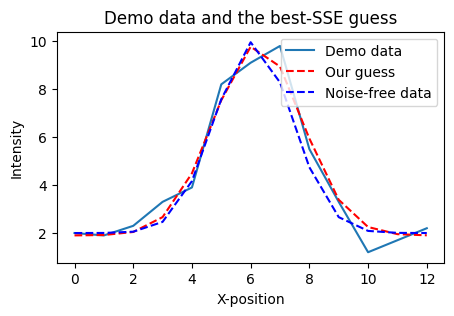

In [17]:
import scipy.stats as stats

x = np.arange(0,13)

I_sim = 30
mu_sim = 6.1
sigma_sim = 1.3
B_sim = 2

# Generate the true Norm dist
gaussian_sim = I_sim*(1/(sigma_best*np.sqrt(2*np.pi)))*np.exp(-(assessment_x_pos-mu_sim)**2/(2*sigma_sim**2))+B_sim
# Generate gaussian noise
noise = stats.norm.rvs(scale=0.8, size=13)
# Combine the signal, and noise
noisy_sim_data = gaussian_sim + noise

print(f"Original data: {[int(x*10)/10 for x in noisy_sim_data]}") #The original data was presented with 1 significant digit

#And let's show them on top of the demo data
plt.figure(figsize=(5,3))
plt.plot(demo_data,label='Demo data')
plt.plot(assessment_x_pos,f_gaussian_best,'r--',label='Our guess')
plt.plot(assessment_x_pos,gaussian_sim,'b--',label='Noise-free data')
plt.title("Demo data and the best-SSE guess")
plt.ylabel('Intensity')
plt.xlabel('X-position')
plt.legend()


The difference between the Noise-free data and our best guess can be interpreted as the localization precision. The underlying emitter generated the noise-free data. The camera recorded that data noisily as the demo data. We fitted this demo data with our guess.

Obviously, in real data, we do not know our true underlying data, but this is the used methodology to test new fitting algorithms.

In [18]:
#From this, we can obtain the 'localization precision' of our fit:
#This is normally done by just getting the absolute difference of the position between true data and fitted data:

print(f"True position: {mu_sim}, found position: {mu_best}")
delta_x = np.abs(mu_sim-mu_best)
print(f'Error of our fit: {delta_x} px')

True position: 6.1, found position: 6.249999999999992
Error of our fit: 0.14999999999999236 px


## Basics done, back to our ROIs!

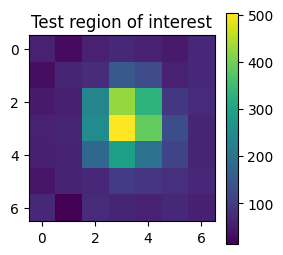

In [19]:
#Let's go back to our ROI data and look at one again:
roi_id_test = 2
test_roi = all_rois[roi_id_test]

plt.figure(figsize=(3,3))
plt.imshow(test_roi)
plt.title('Test region of interest')
plt.colorbar()

First, we need to expand our gaussian to a 2-d gaussian:

$$
f(x,y) = I \cdot \frac{1}{\sigma \sqrt{2\pi}} \exp(-\frac{(x-\mu_x)^2+(y-\mu_y)^2}{2\sigma^2} + B)
$$


(Note: We're assuming a symmetric PSF at the moment, i.e. the spread in x is the same as the one in y)

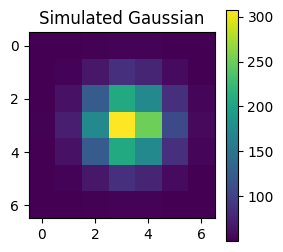

In [20]:
#First, we need to expand our gaussian to a 2-d gaussian:

#For this, we will first make an empty array:
fov_size = 7
gaussian_2d = np.zeros((fov_size,fov_size))

I = 1000
mu_x = 3
mu_y = 3.25
sigma = 1
B = 50

for xx in range(fov_size):
  for yy in range(fov_size):
    gaussian_2d[xx,yy] = I*(1/(sigma_best*np.sqrt(2*np.pi)))*np.exp(-((xx-mu_x)**2+(yy-mu_y)**2)/(2*sigma**2))+B


plt.figure(figsize=(3,3))
plt.imshow(gaussian_2d)
plt.title('Simulated Gaussian')
plt.colorbar()


# ---------- Interaction ------------------
# Play with the parameters and see how it affects the simulated gaussian
# ---------- End interaction --------------

In [21]:
#For ease of operation, and for learning, we will make this a function. A function is simply a piece of code that can be called and gives some output.

#Here is the easiest function ever:
def hello_world_function():
  print('Hello world from a function!')

#This is how we call the function:
hello_world_function()


# ---------- Interaction ------------------
# Add a parameter to the function (hello_world_function(param) )
# Add an output to the function ('return ...')
# ---------- End interaction --------------

Hello world from a function!


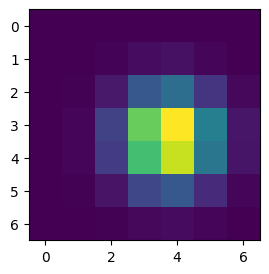

In [22]:
#Now we create the 'draw a 2d gaussian function':

def simulate_gaussian_2d(I=100,mu_x=3,mu_y=3,sigma=1,B=0,fov_size=7):
  gaussian_2d = np.zeros((fov_size,fov_size))
  for xx in range(fov_size):
    for yy in range(fov_size):
      gaussian_2d[xx,yy] = I*(1/(sigma_best*np.sqrt(2*np.pi)))*np.exp(-((xx-mu_x)**2+(yy-mu_y)**2)/(2*sigma**2))+B
  return gaussian_2d #The output of this function is the gaussian

#Call the function like this:
output = simulate_gaussian_2d(I=50,mu_x=3.42,mu_y=3.74,sigma=0.95) #Note: I'm leaving out B and fov_size, they will be set to 0 and 7, respectively!
plt.figure(figsize=(3,3))
plt.imshow(output)


# ---------- Interaction ------------------
# See how it behaves with the pre-set default parameters
# ---------- End interaction --------------

In [23]:
#In principle, we can do the same thing here.
#We can just loop over a bunch of parameters and figure out which has the lowest error.

best_sse = np.inf
best_parameters = [0,0,0,0,0]

#We loop over a lot of different parameters
for mu_x_test in np.arange(3,5,0.2):        #We test the mu between reasonable bounds, every 0.1 pixel
  for mu_y_test in np.arange(3,5,0.2):
    for sigma_test in np.arange(0.5,1.5,0.2):     #Similar for sigma/I/B
      for I_test in np.arange(800,1500,100):
        for B_test in np.arange(40,80,10):
          #We call the function we just created
          test_gaussian = simulate_gaussian_2d(I = I_test,mu_x=mu_x_test,mu_y=mu_y_test,sigma=sigma_test,B=B_test,fov_size=fov_size)

          #We calculate the error AFTER we looped over all xx,yy positions
          sse = np.sum((test_gaussian-test_roi)**2)

          #Now, crucially, we check if this sse is better (lower) than the current-best-sse.
          if sse < best_sse:
            best_sse = sse
            best_parameters = [I_test,mu_x_test,mu_y_test,sigma_test,B_test]

print(f"Found best parameters: {best_parameters}")
print(f"Found best SSE: {best_sse}")

Found best parameters: [np.int64(1400), np.float64(3.0), np.float64(3.2), np.float64(1.0999999999999999), np.int64(60)]
Found best SSE: 50328.01964241586


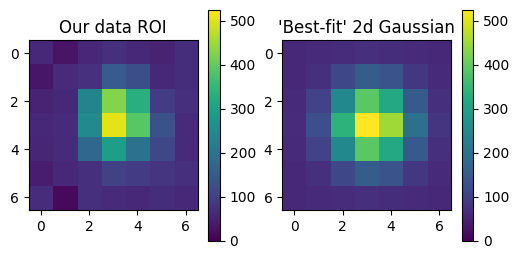

In [24]:
#Similar to before, we show the best-found parameters:
I_best = best_parameters[0]
mu_x_best = best_parameters[1]
mu_y_best = best_parameters[2]
sigma_best = best_parameters[3]
B_best = best_parameters[4]

best_gaussian_2d = simulate_gaussian_2d(I = I_best,mu_x=mu_x_best,mu_y=mu_y_best,sigma=sigma_best,B=B_best,fov_size=fov_size)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

im1 = ax1.imshow(test_roi, cmap='viridis',vmin = 0, vmax = 525)
ax1.set_title('Our data ROI')
fig.colorbar(im1, ax=ax1)

im2 = ax2.imshow(best_gaussian_2d, cmap='viridis',vmin = 0, vmax = 525)
ax2.set_title('\'Best-fit\' 2d Gaussian')
fig.colorbar(im2, ax=ax2)
plt.show()

# ---------- Interaction ------------------
# Determine how many iterations you're using in this fitting - does it become problematic?
# Update the code so you have a different sigma for X and for Y. Does this improve the fitting a lot?
# ---------- End interaction --------------

This needs to be optimized to do the real fitting.

I have taken the lazy approach and (and use this as a tip), asked ChatGPT this:


```
This is my gaussian_2d function:

def simulate_gaussian_2d(I=100,mu_x=3,mu_y=3,sigma=1,B=0,fov_size=7):
  gaussian_2d = np.zeros((fov_size,fov_size))
  for xx in range(fov_size):
    for yy in range(fov_size):
      gaussian_2d[xx,yy] = I*(1/(sigma_best*np.sqrt(2*np.pi)))*np.exp(-((xx-mu_x)**2+(yy-mu_y)**2)/(2*sigma**2))+B
  return gaussian_2d #The output of this function is the gaussian


See what I'm doing here:

best_sse = np.inf
best_parameters = [0,0,0,0,0]

#We loop over a lot of different parameters
for mu_x_test in np.arange(3,5,0.2):        #We test the mu between reasonable bounds, every 0.1 pixel
  for mu_y_test in np.arange(3,5,0.2):
    for sigma_test in np.arange(0.5,1.5,0.2):     #Similar for sigma/I/B
      for I_test in np.arange(800,1500,100):
        for B_test in np.arange(40,80,10):
          #We call the function we just created
          test_gaussian = simulate_gaussian_2d(I = I_test,mu_x=mu_x_test,mu_y=mu_y_test,sigma=sigma_test,B=B_test,fov_size=fov_size)

          #We calculate the error AFTER we looped over all xx,yy positions
          sse = np.sum((test_gaussian-test_roi)**2)

          #Now, crucially, we check if this sse is better (lower) than the current-best-sse.
          if sse < best_sse:
            best_sse = sse
            best_parameters = [I_test,mu_x_test,mu_y_test,sigma_test,B_test]

Make this an actual lsq-fitting routine. Keep it simple. Assume I have the necessary functions and data.
```



This is what it spat out

In [25]:
from scipy.optimize import least_squares

def residuals(params, test_roi, fov_size):
    """
    Function to calculate the residuals for least squares optimization.
    """
    I, mu_x, mu_y, sigma, B = params
    # Generate simulated 2D Gaussian with given parameters
    simulated_gaussian = simulate_gaussian_2d(I, mu_x, mu_y, sigma, B, fov_size)

    # Calculate the residuals (difference between simulated and actual ROI)
    return (simulated_gaussian - test_roi).ravel()

def fit_gaussian_2d(test_roi, fov_size=7):
    """
    Fit the 2D Gaussian model to the provided test ROI using least squares.
    """
    # Initial guess for parameters
    initial_guess = [1000, 3, 3, 1, 50]  # [I, mu_x, mu_y, sigma, B]

    # Use least_squares from scipy to minimize the residuals
    result = least_squares(residuals, initial_guess, args=(test_roi, fov_size))

    # Extract the optimal parameters from the result
    best_parameters = result.x
    return best_parameters

# Example usage:
# Assuming `test_roi` is a 2D numpy array containing the observed region of interest (ROI)

best_parameters = fit_gaussian_2d(test_roi, fov_size=7)
print("Best fit parameters:", best_parameters)

Best fit parameters: [1.35068390e+03 2.75552004e+00 3.21051317e+00 9.75078715e-01
 5.43609417e+01]


## Checking modern generative AI
Let's analyse what it's doing. It's calling the function fit_gaussian_2d. This function calls the scipy.optimize least-squares method. You can read about that function here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html

It has the function 'residuals' as first argument. This is the function whose output it will try to minimize. The function 'residuals' simulates a 2d gaussian with our function, and then takes the *difference* between the simulated gaussian and the test roi, NOT the *difference of squares*. We will fix that.

Next, the least-squares fitting also includes an initial_guess (as a starting point), and two arguments: the ROI to be tested against (i.e. the data), and the FOV size. Those are fine.

Let's fix that one issue:

In [26]:
from scipy.optimize import least_squares

def residuals(params, test_roi, fov_size):
    """
    Function to calculate the residuals for least squares optimization.
    """
    I, mu_x, mu_y, sigma, B = params
    # Generate simulated 2D Gaussian with given parameters
    simulated_gaussian = simulate_gaussian_2d(I, mu_x, mu_y, sigma, B, fov_size)

    # Calculate the residuals (difference between simulated and actual ROI)
    # --------- Fixed ChatGPT here ----------------------
    return ((simulated_gaussian - test_roi)**2).ravel()

def fit_gaussian_2d(test_roi, fov_size=7):
    """
    Fit the 2D Gaussian model to the provided test ROI using least squares.
    """
    # Initial guess for parameters
    initial_guess = [1000, 3, 3, 1, 50]  # [I, mu_x, mu_y, sigma, B]

    # Use least_squares from scipy to minimize the residuals
    result = least_squares(residuals, initial_guess, args=(test_roi, fov_size))

    # Extract the optimal parameters from the result
    best_parameters = result.x
    return best_parameters

# Example usage:
# Assuming `test_roi` is a 2D numpy array containing the observed region of interest (ROI)

best_parameters = fit_gaussian_2d(test_roi, fov_size=7)
print("Best fit parameters:", best_parameters)


# ---------- Interaction ------------------
# Calculate the differences in x and y of this method compared to our brute-force method. Is that expected given our search space?
# ---------- End interaction --------------

Best fit parameters: [1.37057825e+03 2.77190071e+00 3.21648618e+00 9.83278459e-01
 4.90461857e+01]


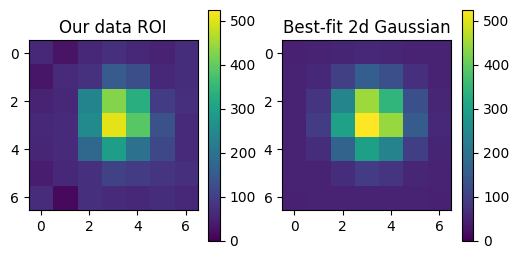

In [27]:
#Comparing the two outputs, we see that the fitting result indeed changed a little bit!

#Finally, let's visualise the best fit:
I_best = best_parameters[0]
mu_x_best = best_parameters[1]
mu_y_best = best_parameters[2]
sigma_best = best_parameters[3]
B_best = best_parameters[4]

best_gaussian_2d = simulate_gaussian_2d(I = I_best,mu_x=mu_x_best,mu_y=mu_y_best,sigma=sigma_best,B=B_best,fov_size=fov_size)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

im1 = ax1.imshow(test_roi, cmap='viridis',vmin = 0, vmax = 525)
ax1.set_title('Our data ROI')
fig.colorbar(im1, ax=ax1)

im2 = ax2.imshow(best_gaussian_2d, cmap='viridis',vmin = 0, vmax = 525)
ax2.set_title('Best-fit 2d Gaussian')
fig.colorbar(im2, ax=ax2)
plt.show()

Amazing, all seems to work.

Now, so far, we used least-squares fitting. Following this paper:
https://chemistry-europe.onlinelibrary.wiley.com/doi/10.1002/cphc.201300711

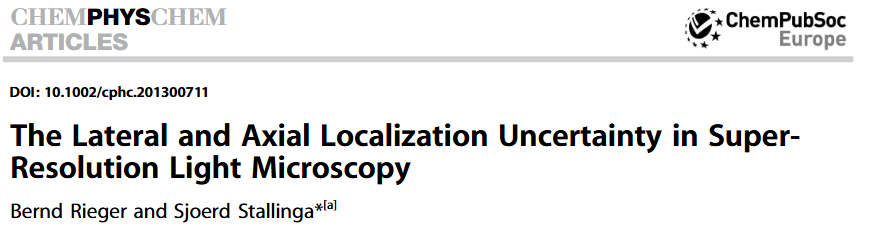

We have followed indeed the least-squares option. They also provide a 'maximum likelihood' option:

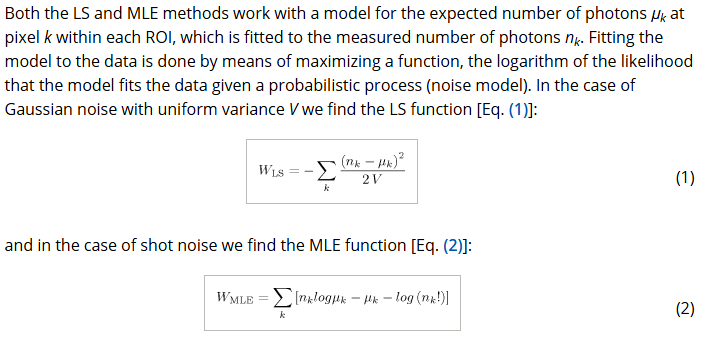

And they mention that the MLE method slightly out-performs the least-squares method:

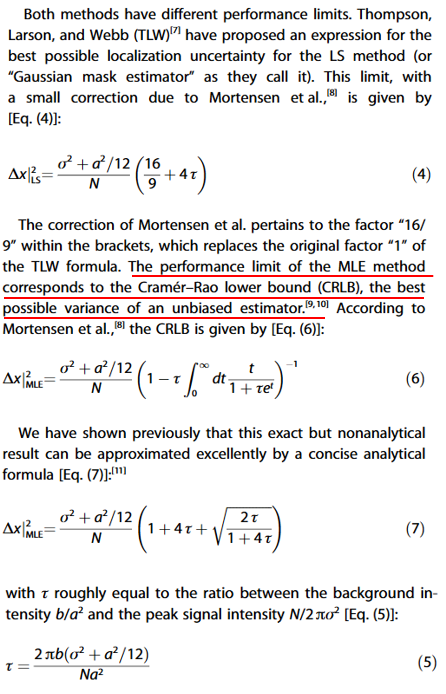

In [28]:
#Let's investigate how much better MLE can theoretically be compared to LS:

N = 10000 #Total intensity
a = 100 #pixel size, in nm
b_px = 1 #Background per pixel
sigma = .95 #in px units

#They use a pixel-size-correct background value b for their calculations
b = b_px*(a**2)

tau = 2*np.pi*b*(sigma**2+a**2/12)/(N*a**2)
d_x_LS = ((sigma**2+(a**2)/12)/N)*(16/9+4*tau)
d_x_MLE = ((sigma**2+(a**2)/12)/N)*(1+4*tau+np.sqrt(2*tau/(1+4*tau)))

print(f"LS error: {d_x_LS}, MLE error: {d_x_MLE}")
print(f"Improvement: {(1-d_x_MLE/d_x_LS)*100} %")


# ---------- Interaction ------------------
# The difference between Least Squares and MLE becomes smaller and smaller with increasing background. Verify this.
# ---------- End interaction --------------

LS error: 0.32321976081575565, MLE error: 0.3068737931318824
Improvement: 5.05723030133387 %


To perform MLE rather than LS, we only need to change the residuals function:

Best fit parameters MLE: [1.20000001e+03 2.79748866e+00 3.22635749e+00 9.94633387e-01
 5.02176006e+01]


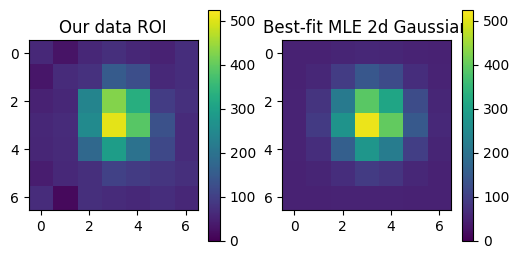

In [29]:
from scipy.optimize import least_squares
import math

def residuals_MLE(params, test_roi, fov_size):
    """
    Function to calculate the residuals for least squares optimization.
    """
    I, mu_x, mu_y, sigma, B = params
    # Generate simulated 2D Gaussian with given parameters
    simulated_gaussian = simulate_gaussian_2d(I, mu_x, mu_y, sigma, B, fov_size)

    # Calculate the residuals (difference between simulated and actual ROI)
    # --------- Changed to MLE here
    MLE_sum = 0
    for xx in range(fov_size):
      for yy in range(fov_size):
        MLE_sum += test_roi[xx,yy]*math.log(simulated_gaussian[xx,yy])-simulated_gaussian[xx,yy]-math.log(math.factorial(np.int64(test_roi[xx,yy])))
    return (MLE_sum).ravel()

def fit_gaussian_2d_MLE(test_roi, fov_size=7):
    """
    Fit the 2D Gaussian model to the provided test ROI using least squares.
    """
    # Initial guess for parameters
    initial_guess = [1200, 2.5, 3, 0.8, 50]  # [I, mu_x, mu_y, sigma, B]

    # Use least_squares from scipy to minimize the residuals
    result = least_squares(residuals_MLE, initial_guess, args=(test_roi, fov_size))

    # Extract the optimal parameters from the result
    best_parameters = result.x
    return best_parameters

best_parameters = fit_gaussian_2d_MLE(test_roi, fov_size=7)
print("Best fit parameters MLE:", best_parameters)

#Finally, let's visualise the best fit:
I_best = best_parameters[0]
mu_x_best = best_parameters[1]
mu_y_best = best_parameters[2]
sigma_best = best_parameters[3]
B_best = best_parameters[4]

best_gaussian_2d = simulate_gaussian_2d(I = I_best,mu_x=mu_x_best,mu_y=mu_y_best,sigma=sigma_best,B=B_best,fov_size=fov_size)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

im1 = ax1.imshow(test_roi, cmap='viridis',vmin = 0, vmax = 525)
ax1.set_title('Our data ROI')
fig.colorbar(im1, ax=ax1)

im2 = ax2.imshow(best_gaussian_2d, cmap='viridis',vmin = 0, vmax = 525)
ax2.set_title('Best-fit MLE 2d Gaussian')
fig.colorbar(im2, ax=ax2)
plt.show()

Note that this is quite a bit slower than Least squares, since we don't optimize for speed here. We will stick with the LSQ in the foreseeable future.

## Bring it all together to do LSQ fit of all found spots

In [30]:
#Good, finally, we use the code to fit all ROIs that we found:

#We create an empty matrix that we fill in. We get 5 fit params for each roi.
fit_params_matrix = np.zeros((len(all_rois),5))

#We loop over all the ROIs and fit them:
for roi_id in range(len(all_rois)):
  this_roi = all_rois[roi_id]
  fit_params_matrix[roi_id,:] = fit_gaussian_2d(this_roi, fov_size=7)

print('Fit results (intensity, x_pos (nm), y_pos (nm), sigma (nm), bg):')
with np.printoptions(precision=2, suppress=True): #2 significant digit, suppress exponential notation for <e^3
    print(fit_params_matrix)

Fit results (intensity, x_pos (nm), y_pos (nm), sigma (nm), bg):
[[ 224.28    2.73    2.73    0.83   33.28]
 [ 550.1     2.92    3.48    0.86   45.7 ]
 [1239.3     2.77    3.22    0.98   49.05]
 [1762.41    3.02    3.21    0.99   53.24]
 [ 682.54    2.99    2.83    1.03   42.21]
 [1396.01    2.72    2.86    0.99   50.32]
 [ 180.3     2.47    2.35    1.07   35.23]
 [1298.24    2.8     3.45    1.03   51.24]
 [1553.07    2.99    2.88    0.97   65.55]
 [2259.89    3.55    3.5     1.01   59.  ]
 [1519.34    3.16    2.74    0.97   59.73]
 [ 595.67    3.28    3.39    1.05   46.68]
 [1652.8     3.48    2.64    0.98   62.42]
 [1361.87    2.69    2.59    1.     59.63]
 [1516.65    3.58    2.57    1.04   50.19]
 [ 810.53    2.81    2.59    1.06   42.37]
 [ 531.5     3.22    3.2     1.05   43.85]
 [1333.43    2.87    3.27    0.98   52.82]]


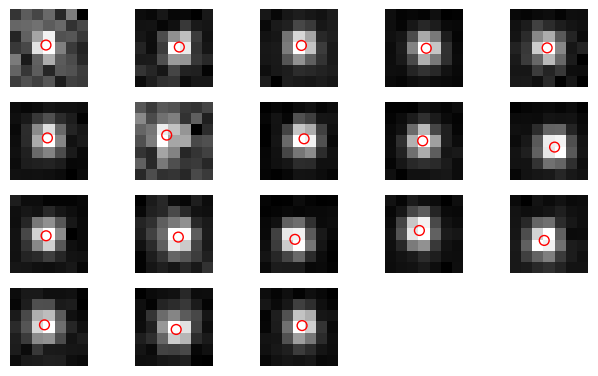

In [31]:
#We repeat the earlier ROI-plot and add the found localizations for inspection:

subplot_1d_size = int(np.ceil(np.sqrt(len(all_rois))))

plt.figure()
for roi_id in range(len(all_rois)):
  plt.subplot(subplot_1d_size,subplot_1d_size,roi_id+1)
  plt.imshow(all_rois[roi_id],cmap='gray')
  plt.scatter(fit_params_matrix[roi_id,2],fit_params_matrix[roi_id,1],s=50,color='r',marker='o',facecolor='none') #Remember plt swaps Y and X axes...
  plt.gca().axis('off') #Turn off the axis for this current subplot
plt.tight_layout()

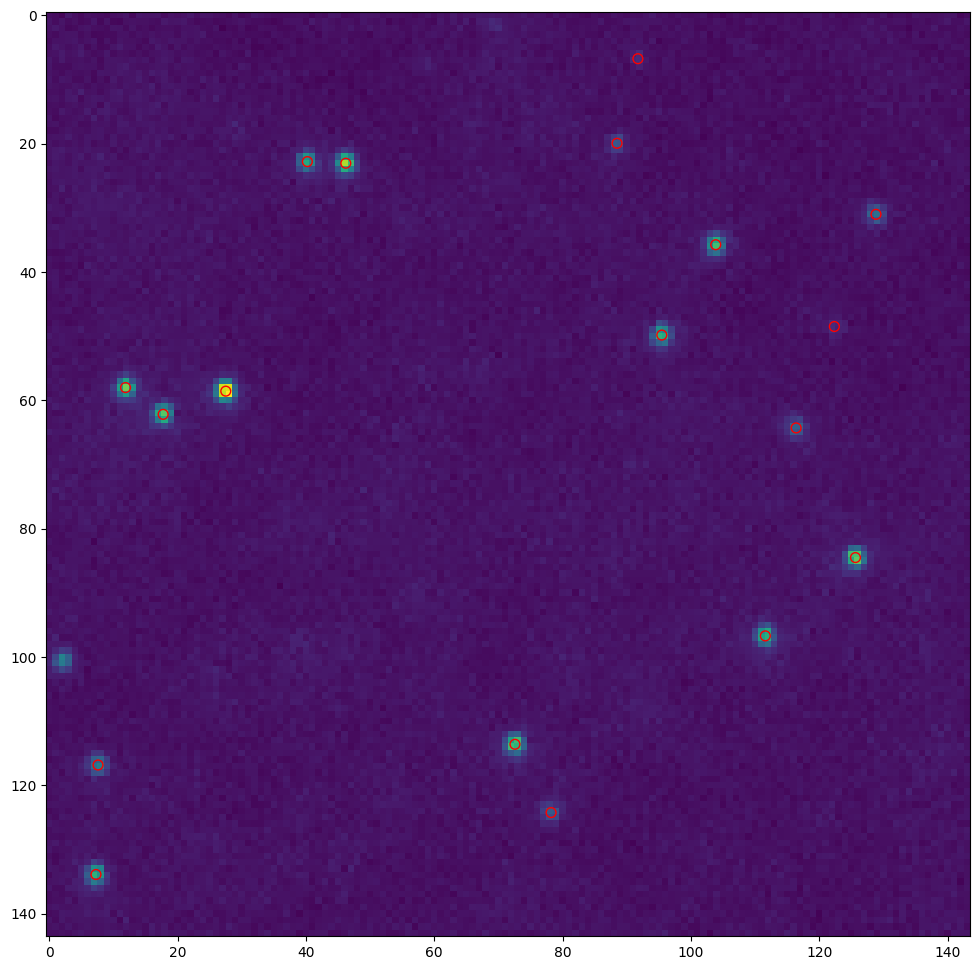

In [32]:
#Finally, we come back to our original frame, and plot all found localizations:

plt.figure(figsize = (12,12))
plt.imshow(singleFrame)
#Please note! The plt imshow flips x and y, so we need to plot the scatter like y-vs-x.
for roi_id in range(len(all_rois)):
  subpixel_roi_pos = [ all_roi_positions[roi_id][0]-roi_px_radius+fit_params_matrix[roi_id,1], #Add the sub-pixel x-pos to the segmentation middle pixel
                      all_roi_positions[roi_id][1]-roi_px_radius+fit_params_matrix[roi_id,2]] #Same for Y
  plt.scatter(subpixel_roi_pos[1], subpixel_roi_pos[0], s = 50, color='r', marker='o', facecolor='none') #Note flipping of x,y due to plt

# ---------- Interaction ------------------
# Make the image a lot larger and investigate that the localization is good
# Plot the central-pixel (i.e. without sub-pixel localization) and see how more wrong that is
# ---------- End interaction --------------

# Chapter 2b: putting full localization pipeline together

In [33]:
#Knowing the full pipeline, lets clean up the code and make a nice function.
# We want to create the function such that we only provide the full frame image in it, and it spits out the list of sub-pixel localizations
# It should also optionally visualise them.


# ---------- Interaction ------------------
# Do not yet look at the function below! Try to make it yourself!
# First think about which input parameters you need. You need the image, but probably also some info about which FOV size, which segmentation threshold, etc etc.
# ---------- End interaction --------------

In [34]:
#Make-your-own-function













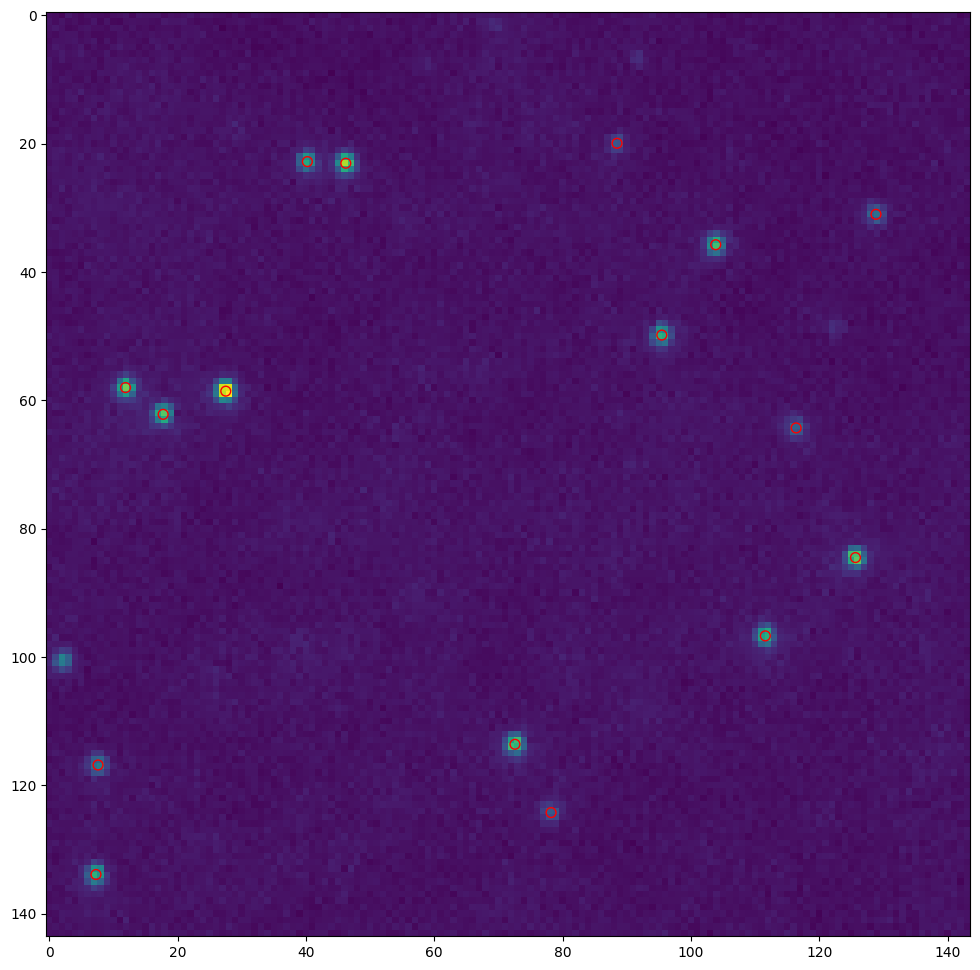

In [35]:
#My function:
from scipy.ndimage import uniform_filter, grey_dilation

def localization_from_frame(frame,gain=50,offset=30,fov_size=7,segmentation_threshold=20,na=1.49,pixelsize=100,wavelength=660,visualisation=False):

  # --- Step 1: Pre-processing -----
  singleFrame_raw = frame
  singleFrame = singleFrame_raw/gain-offset

  # --- Step 2: segmentation ------

  sigma_psf = wavelength / (4.0 * na * pixel_size)

  q_a1_1 = 2 * sigma_psf + 1
  q_a1_2 = 2*(2 * sigma_psf + 1)
  q_a2 = int(5 * sigma_psf)

  # Step 1: Bandpass filtering
  # Enhances features roughly PSF-sized while suppressing background
  A1 = uniform_filter(singleFrame, q_a1_1) - uniform_filter(singleFrame, q_a1_2)
  # Step 2: Local maximum filtering
  # Detect candidate emitters by finding local maxima
  A2 = grey_dilation(A1, size=(q_a2, q_a2))  # max filter in neighborhood
  # Step 3: Select true local peaks
  A3 = (A1 == A2) & (A1 > segmentation_threshold)

  # --- Step 3: ROI extraction ------
  roi_px_radius = int((fov_size-1)/2)

  roixy_pos = np.argwhere(A3==1) #np.argwhere returns the coordinates where the condition is true.

  #We pre-allocate an array - we fill this with the data
  all_rois = []
  all_roi_positions = []

  for roi_id in range(len(roixy_pos)):
    x_roi = roixy_pos[roi_id][0]
    y_roi = roixy_pos[roi_id][1]
    this_roi = singleFrame[x_roi-roi_px_radius:x_roi+roi_px_radius+1,
                          y_roi-roi_px_radius:y_roi+roi_px_radius+1]
    if np.shape(this_roi) == (roi_px_size,roi_px_size):
      #We append the ROI to the matrix 'all_rois'
      all_rois.append(this_roi)
      all_roi_positions.append([x_roi,y_roi]) #We also store the middle-pixel positions for later.

  # --- Step 4: LSQ fitting ------
  #Ensure we have our fitting functions ready:
  def residuals(params, test_roi, fov_size):
      """
      Function to calculate the residuals for least squares optimization.
      """
      I, mu_x, mu_y, sigma, B = params
      # Generate simulated 2D Gaussian with given parameters
      simulated_gaussian = simulate_gaussian_2d(I, mu_x, mu_y, sigma, B, fov_size)

      # Calculate the residuals (difference between simulated and actual ROI)
      # --------- Fixed ChatGPT here ----------------------
      return ((simulated_gaussian - test_roi)**2).ravel()

  def fit_gaussian_2d(test_roi, fov_size=7):
      """
      Fit the 2D Gaussian model to the provided test ROI using least squares.
      """
      # Initial guess for parameters
      initial_guess = [1000, 3, 3, 1, 50]  # [I, mu_x, mu_y, sigma, B]

      # Use least_squares from scipy to minimize the residuals
      result = least_squares(residuals, initial_guess, args=(test_roi, fov_size))

      # Extract the optimal parameters from the result
      best_parameters = result.x
      return best_parameters

  #We create an empty matrix that we fill in. We get 5 fit params for each roi.
  fit_params_matrix = np.zeros((len(all_rois),5))

  #We loop over all the ROIs and fit them:
  for roi_id in range(len(all_rois)):
    this_roi = all_rois[roi_id]
    fit_params_matrix[roi_id,:] = fit_gaussian_2d(this_roi, fov_size=7)

  # --- Step 5: Visualisation if wanted -----
  if visualisation:
    plt.figure(figsize = (12,12))
    plt.imshow(frame)
    #Please note! The plt imshow flips x and y, so we need to plot the scatter like y-vs-x.
    for roi_id in range(len(all_rois)):
      subpixel_roi_pos = [ all_roi_positions[roi_id][0]-roi_px_radius+fit_params_matrix[roi_id,1], #Add the sub-pixel x-pos to the segmentation middle pixel
                          all_roi_positions[roi_id][1]-roi_px_radius+fit_params_matrix[roi_id,2]] #Same for Y
      plt.scatter(subpixel_roi_pos[1], subpixel_roi_pos[0], s = 50, color='r', marker='o', facecolor='none') #Note flipping of x,y due to plt

  # --- Step 6: Return data -----
  #We add the ROI pixel offset to the fit positions
  fit_params_matrix[1]+=all_roi_positions[roi_id][0]-roi_px_radius
  fit_params_matrix[2]+=all_roi_positions[roi_id][1]-roi_px_radius

  return fit_params_matrix

#Call the function and test!
all_locs = localization_from_frame(im[30,:,:],gain=50,offset=30,fov_size=7,segmentation_threshold=30,na=1.49,pixelsize=100,wavelength=660,visualisation=True)

# ---------- Interaction ------------------
# Test it out on different frames! Change parameters, see what's what!
# ---------- End interaction --------------